Name:   
Matrikelnummer:  
Email:   
   
Name:   
Matrikelnummer:   
Email:

Name:    
Matrikelnummer:    
Email:    

#### Preamble

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

from tqdm import tqdm

# 8.2 Using different Optimizers

In this exercise you get to use your previously built networks, but this time we will play around with different optimizers and have a brief introduction to schedulers (Bonus)

### 8.2.1 AdaGrad, Adam, SGD

In this exercise reuse your deep regularized network from Assignment 7 (using `torch`) and train your model with different optimizers, namely AdaGrad, Adam, and SGD. (**1 point**)

Report your accuracy and $F_1 score$ matrices for training and test set. Do you see any difference in the matrices with rergards to number of epochs? (**0.5 point**)

Plot the values of your training loss for all three optimizers. Does your observation of differences match what you expected? (**0.5 point**)

In another plot, visualize the weight update trajectories of your model when using different optimizers.

*You should keep in mind that while generating points for plotting, you should keep other hyperparameters constant. This provides you a better sense of performance comparison.*

In [29]:
class Model(nn.Module):
    """
    Implement a model that incorporates dropout and L2 regularization
    depending on arguments passed.

    Args:
    input_dim: dimensionality of the inputs
    hidden_dim: how many units each hidden layer will have
    out_dim: how many output units
    num_layers: how many hidden layers to create/use
    dropout: a list of booleans specifying which hidden layers will have dropout
    dropout_p: the probability used for the `Dropout` layers
    l2_reg: a boolean value that indicates whether L2 regularization should be used
    """

    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 out_dim: int,
                 num_layers: int,
                 dropout: list,
                 dropout_p: float,
                 l2_reg: bool):
        super().__init__()

        self.l2_reg = l2_reg

        layers = []

        layers.append(nn.Flatten())
        layers.append(nn.Linear(input_dim, hidden_dim, bias=True))
        layers.append(nn.ReLU())

        if dropout[0]:
            layers.append(nn.Dropout(dropout_p))

        for i in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim, bias=True))
            layers.append(nn.ReLU())
            if dropout[i + 1]:
                layers.append(nn.Dropout(dropout_p))

        layers.append(nn.Linear(hidden_dim, out_dim))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return F.softmax(self.layers.forward(x), dim=1)

def fit(model, train_loader, test_loader, optimizer:str, epochs=1, alpha=1e-5, lr=1e-4, cuda:bool = True):
    # define optimizer
    if optimizer == 'sgd':
        optimizer = torch.optim.SGD(lr=lr, params=model.parameters(), weight_decay=alpha)
    elif optimizer == 'adam':
        optimizer = torch.optim.Adam(lr=lr, params=model.parameters(), weight_decay=alpha)
    elif optimizer == 'adagrad':
        optimizer = torch.optim.Adagrad(lr=lr, params=model.parameters(), weight_decay=alpha)

    if cuda:
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()

    train_f1s = []
    train_accuracys = []

    test_accuracys = []
    test_f1s = []

    for epoch in range(epochs):
        print('epoch:', epoch)
        # print("#" * 50, "epoch:", epoch, "#"*50)

        train_loss = torch.tensor(0.0)
        test_loss = torch.tensor(0.0)
        if cuda:
            train_loss = train_loss.cuda()
            test_loss = test_loss.cuda()

        i = 0

        # train
        # print('training...')
        targets = []
        predictions = []
        for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
            if cuda:
                x = x.cuda()
                y = y.cuda()
            optimizer.zero_grad()

            # forward pass
            pred = model.forward(x)

            # optimizer stuff
            loss = criterion(pred, y)
            loss.backward()

            train_loss += loss
            optimizer.step()

            _, p = torch.max(pred, 1)
            # accuracy/f1
            for i in range(pred.shape[0]):
                targets.append(y[i])
                predictions.append(p[i])

        train_loss /= len(train_loader)
        train_loss = train_loss.detach().cpu()
        # print('train loss:', train_loss.item())

        targets = torch.tensor(targets)
        predictions = torch.tensor(predictions)

        # accuracy
        train_accuracy = torch.sum(targets == predictions) / targets.shape[0]
        train_f1 = f1_loss(targets, predictions)

        # print('testing...')
        with torch.no_grad():
            targets = []
            outputs = []

            for i, (x, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                pred = model.forward(x)
                loss = criterion(pred, y)

                test_loss += loss

                for i in range(pred.shape[0]):
                    _, predicted = torch.max(pred[i], 0)
                    outputs.append(predicted)
                    targets.append(y[i])

            outputs = torch.tensor(outputs)
            targets = torch.tensor(targets)

            test_f1 = f1_loss(targets, outputs)
            test_accuracy = torch.sum(targets == outputs) / targets.shape[0]

            test_loss /= len(test_loader)
            # print('train loss:', test_loss.item())

        print(
            'F1:', f'train: {train_f1:.3g}', f'test: {test_f1:.3g}'
        )
        print(
            'Accuracy:', f'train: {train_accuracy:.3g}', f'test: {test_accuracy:.3g}'
        )
        print(
            'Loss:', f'train: {train_loss:.3g}', f'test: {test_loss:.3g}'
        )

        train_f1s.append(train_f1)
        test_f1s.append(test_f1)

        train_accuracys.append(train_accuracy)
        test_accuracys.append(test_accuracy)

    return train_f1s, test_f1s, train_accuracys, test_accuracys

In [30]:
def f1_loss(y_true: torch.Tensor, y_pred: torch.Tensor, is_training=False) -> torch.Tensor:
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2

    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)

    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)

    epsilon = 1e-7

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1

In [31]:
# Load the data
# DO NOT CHANGE THE CODE IN THIS CELL EXCEPT FOR THE BATCH SIZE IF NECESSARY
transform_fn = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.7,), (0.7,)), ])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_fn)
train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_fn)
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=False)

# Use the above data for your experiments

In [34]:
def init_model():
    return Model(
        input_dim=28*28,
        hidden_dim=256,
        out_dim=10,
        num_layers=3,
        dropout=[False, False, False, False],
        dropout_p=0.5,
        l2_reg=False
    )

LR = 5e-5
EPOCHS=50

# sgd
model = init_model()
f1_train_sgd, f1_test_sgd, train_acc_sgd, test_acc_sgd = fit(model, train_dl, test_dl, optimizer='sgd', epochs=EPOCHS, lr=LR, alpha=0)

# adam
model = init_model()
f1_train_adam, f1_test_adam, train_acc_adam, test_acc_adam = fit(model, train_dl, test_dl, optimizer='adam', epochs=EPOCHS, lr=LR, alpha=0)

# adagrad
model = init_model()
f1_train_adagrad, f1_test_adagrad, train_acc_adagrad, test_acc_adagrad = fit(model, train_dl, test_dl, optimizer='adagrad', epochs=EPOCHS, lr=LR, alpha=0, cuda=False)

epoch: 0


100%|██████████| 313/313 [00:02<00:00, 113.04it/s]


F1: train: 5.42 test: 5.42
Accuracy: train: 0.117 test: 0.118
Loss: train: 2.3 test: 2.3
epoch: 1


100%|██████████| 313/313 [00:02<00:00, 109.42it/s]


F1: train: 5.43 test: 5.42
Accuracy: train: 0.117 test: 0.118
Loss: train: 2.3 test: 2.3
epoch: 2


100%|██████████| 313/313 [00:02<00:00, 107.73it/s]


F1: train: 5.43 test: 5.43
Accuracy: train: 0.117 test: 0.118
Loss: train: 2.3 test: 2.3
epoch: 3


100%|██████████| 313/313 [00:02<00:00, 109.36it/s]


F1: train: 5.43 test: 5.43
Accuracy: train: 0.118 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 4


100%|██████████| 313/313 [00:02<00:00, 110.80it/s]


F1: train: 5.44 test: 5.43
Accuracy: train: 0.118 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 5


100%|██████████| 313/313 [00:02<00:00, 110.29it/s]


F1: train: 5.44 test: 5.44
Accuracy: train: 0.118 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 6


100%|██████████| 313/313 [00:02<00:00, 115.84it/s]


F1: train: 5.44 test: 5.44
Accuracy: train: 0.118 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 7


100%|██████████| 313/313 [00:02<00:00, 109.90it/s]


F1: train: 5.45 test: 5.44
Accuracy: train: 0.118 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 8


100%|██████████| 313/313 [00:02<00:00, 111.11it/s]


F1: train: 5.45 test: 5.45
Accuracy: train: 0.118 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 9


100%|██████████| 313/313 [00:02<00:00, 112.39it/s]


F1: train: 5.45 test: 5.45
Accuracy: train: 0.118 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 10


100%|██████████| 313/313 [00:02<00:00, 108.72it/s]


F1: train: 5.45 test: 5.45
Accuracy: train: 0.118 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 11


100%|██████████| 313/313 [00:02<00:00, 111.26it/s]


F1: train: 5.45 test: 5.45
Accuracy: train: 0.118 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 12


100%|██████████| 313/313 [00:02<00:00, 112.79it/s]


F1: train: 5.45 test: 5.46
Accuracy: train: 0.118 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 13


100%|██████████| 313/313 [00:02<00:00, 104.54it/s]


F1: train: 5.46 test: 5.46
Accuracy: train: 0.118 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 14


100%|██████████| 313/313 [00:02<00:00, 108.64it/s]


F1: train: 5.46 test: 5.46
Accuracy: train: 0.118 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 15


100%|██████████| 313/313 [00:02<00:00, 107.12it/s]


F1: train: 5.46 test: 5.46
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 16


100%|██████████| 313/313 [00:02<00:00, 108.64it/s]


F1: train: 5.46 test: 5.46
Accuracy: train: 0.118 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 17


100%|██████████| 313/313 [00:02<00:00, 104.51it/s]


F1: train: 5.46 test: 5.46
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 18


100%|██████████| 313/313 [00:03<00:00, 102.59it/s]


F1: train: 5.46 test: 5.46
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 19


100%|██████████| 313/313 [00:03<00:00, 97.48it/s] 


F1: train: 5.46 test: 5.46
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 20


100%|██████████| 313/313 [00:03<00:00, 101.43it/s]


F1: train: 5.46 test: 5.46
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 21


100%|██████████| 313/313 [00:02<00:00, 108.08it/s]


F1: train: 5.46 test: 5.47
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 22


100%|██████████| 313/313 [00:02<00:00, 109.59it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 23


100%|██████████| 313/313 [00:02<00:00, 108.76it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 24


100%|██████████| 313/313 [00:02<00:00, 107.89it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 25


100%|██████████| 313/313 [00:02<00:00, 107.08it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 26


100%|██████████| 313/313 [00:02<00:00, 109.90it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 27


100%|██████████| 313/313 [00:02<00:00, 110.95it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 28


100%|██████████| 313/313 [00:02<00:00, 104.44it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 29


100%|██████████| 313/313 [00:03<00:00, 101.89it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 30


100%|██████████| 313/313 [00:03<00:00, 100.19it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 31


100%|██████████| 313/313 [00:03<00:00, 103.03it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 32


100%|██████████| 313/313 [00:03<00:00, 103.09it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 33


100%|██████████| 313/313 [00:02<00:00, 110.44it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 34


100%|██████████| 313/313 [00:02<00:00, 107.12it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 35


100%|██████████| 313/313 [00:03<00:00, 102.62it/s]


F1: train: 5.47 test: 5.47
Accuracy: train: 0.119 test: 0.119
Loss: train: 2.3 test: 2.3
epoch: 36


100%|██████████| 313/313 [00:03<00:00, 101.25it/s]


F1: train: 5.47 test: 5.48
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 37


100%|██████████| 313/313 [00:03<00:00, 101.79it/s]


F1: train: 5.47 test: 5.48
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 38


100%|██████████| 313/313 [00:03<00:00, 101.89it/s]


F1: train: 5.47 test: 5.48
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 39


100%|██████████| 313/313 [00:03<00:00, 102.39it/s]


F1: train: 5.47 test: 5.48
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 40


100%|██████████| 313/313 [00:03<00:00, 97.27it/s]


F1: train: 5.47 test: 5.48
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 41


100%|██████████| 313/313 [00:03<00:00, 101.49it/s]


F1: train: 5.48 test: 5.48
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 42


100%|██████████| 313/313 [00:03<00:00, 101.81it/s]


F1: train: 5.48 test: 5.48
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 43


100%|██████████| 313/313 [00:03<00:00, 102.49it/s]


F1: train: 5.48 test: 5.48
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 44


100%|██████████| 313/313 [00:03<00:00, 103.95it/s]


F1: train: 5.48 test: 5.48
Accuracy: train: 0.119 test: 0.12
Loss: train: 2.3 test: 2.3
epoch: 45


100%|██████████| 313/313 [00:03<00:00, 102.99it/s]


F1: train: 5.48 test: 5.48
Accuracy: train: 0.119 test: 0.121
Loss: train: 2.3 test: 2.3
epoch: 46


100%|██████████| 313/313 [00:02<00:00, 109.17it/s]


F1: train: 5.48 test: 5.48
Accuracy: train: 0.119 test: 0.121
Loss: train: 2.3 test: 2.3
epoch: 47


100%|██████████| 313/313 [00:03<00:00, 104.23it/s]


F1: train: 5.48 test: 5.48
Accuracy: train: 0.119 test: 0.121
Loss: train: 2.3 test: 2.3
epoch: 48


100%|██████████| 313/313 [00:02<00:00, 108.91it/s]


F1: train: 5.48 test: 5.48
Accuracy: train: 0.119 test: 0.121
Loss: train: 2.3 test: 2.3
epoch: 49


100%|██████████| 313/313 [00:03<00:00, 100.84it/s]


F1: train: 5.48 test: 5.49
Accuracy: train: 0.12 test: 0.122
Loss: train: 2.3 test: 2.3
epoch: 0


100%|██████████| 313/313 [00:02<00:00, 108.98it/s]


F1: train: 5.57 test: 6.11
Accuracy: train: 0.689 test: 0.868
Loss: train: 1.82 test: 1.63
epoch: 1


100%|██████████| 313/313 [00:03<00:00, 103.26it/s]


F1: train: 6.11 test: 6.15
Accuracy: train: 0.878 test: 0.897
Loss: train: 1.6 test: 1.58
epoch: 2


100%|██████████| 313/313 [00:02<00:00, 108.27it/s]


F1: train: 6.13 test: 6.14
Accuracy: train: 0.896 test: 0.904
Loss: train: 1.58 test: 1.56
epoch: 3


100%|██████████| 313/313 [00:02<00:00, 109.25it/s]


F1: train: 6.14 test: 6.17
Accuracy: train: 0.904 test: 0.914
Loss: train: 1.56 test: 1.55
epoch: 4


100%|██████████| 313/313 [00:02<00:00, 106.83it/s]


F1: train: 6.16 test: 6.2
Accuracy: train: 0.912 test: 0.912
Loss: train: 1.56 test: 1.55
epoch: 5


100%|██████████| 313/313 [00:03<00:00, 100.84it/s]


F1: train: 6.17 test: 6.21
Accuracy: train: 0.916 test: 0.916
Loss: train: 1.55 test: 1.55
epoch: 6


100%|██████████| 313/313 [00:03<00:00, 100.74it/s]


F1: train: 6.17 test: 6.12
Accuracy: train: 0.921 test: 0.922
Loss: train: 1.55 test: 1.54
epoch: 7


100%|██████████| 313/313 [00:02<00:00, 106.28it/s]


F1: train: 6.18 test: 6.18
Accuracy: train: 0.925 test: 0.929
Loss: train: 1.54 test: 1.53
epoch: 8


100%|██████████| 313/313 [00:02<00:00, 106.10it/s]


F1: train: 6.19 test: 6.17
Accuracy: train: 0.93 test: 0.932
Loss: train: 1.54 test: 1.53
epoch: 9


100%|██████████| 313/313 [00:03<00:00, 99.94it/s] 


F1: train: 6.19 test: 6.21
Accuracy: train: 0.934 test: 0.932
Loss: train: 1.53 test: 1.53
epoch: 10


100%|██████████| 313/313 [00:02<00:00, 104.89it/s]


F1: train: 6.2 test: 6.16
Accuracy: train: 0.937 test: 0.936
Loss: train: 1.53 test: 1.53
epoch: 11


100%|██████████| 313/313 [00:02<00:00, 107.12it/s]


F1: train: 6.2 test: 6.2
Accuracy: train: 0.939 test: 0.94
Loss: train: 1.53 test: 1.52
epoch: 12


100%|██████████| 313/313 [00:02<00:00, 106.25it/s]


F1: train: 6.21 test: 6.23
Accuracy: train: 0.943 test: 0.943
Loss: train: 1.52 test: 1.52
epoch: 13


100%|██████████| 313/313 [00:03<00:00, 103.30it/s]


F1: train: 6.21 test: 6.22
Accuracy: train: 0.944 test: 0.945
Loss: train: 1.52 test: 1.52
epoch: 14


100%|██████████| 313/313 [00:02<00:00, 104.37it/s]


F1: train: 6.22 test: 6.22
Accuracy: train: 0.947 test: 0.943
Loss: train: 1.52 test: 1.52
epoch: 15


100%|██████████| 313/313 [00:03<00:00, 101.36it/s]


F1: train: 6.23 test: 6.24
Accuracy: train: 0.95 test: 0.951
Loss: train: 1.51 test: 1.51
epoch: 16


100%|██████████| 313/313 [00:03<00:00, 103.30it/s]


F1: train: 6.23 test: 6.2
Accuracy: train: 0.951 test: 0.947
Loss: train: 1.51 test: 1.52
epoch: 17


100%|██████████| 313/313 [00:03<00:00, 102.59it/s]


F1: train: 6.23 test: 6.21
Accuracy: train: 0.954 test: 0.954
Loss: train: 1.51 test: 1.51
epoch: 18


100%|██████████| 313/313 [00:02<00:00, 106.35it/s]


F1: train: 6.24 test: 6.24
Accuracy: train: 0.956 test: 0.954
Loss: train: 1.51 test: 1.51
epoch: 19


100%|██████████| 313/313 [00:03<00:00, 98.00it/s] 


F1: train: 6.24 test: 6.25
Accuracy: train: 0.958 test: 0.952
Loss: train: 1.51 test: 1.51
epoch: 20


100%|██████████| 313/313 [00:03<00:00, 99.49it/s] 


F1: train: 6.24 test: 6.22
Accuracy: train: 0.959 test: 0.957
Loss: train: 1.5 test: 1.51
epoch: 21


100%|██████████| 313/313 [00:02<00:00, 107.05it/s]


F1: train: 6.24 test: 6.22
Accuracy: train: 0.961 test: 0.957
Loss: train: 1.5 test: 1.51
epoch: 22


100%|██████████| 313/313 [00:03<00:00, 103.74it/s]


F1: train: 6.25 test: 6.22
Accuracy: train: 0.962 test: 0.957
Loss: train: 1.5 test: 1.51
epoch: 23


100%|██████████| 313/313 [00:02<00:00, 106.75it/s]


F1: train: 6.25 test: 6.23
Accuracy: train: 0.963 test: 0.959
Loss: train: 1.5 test: 1.5
epoch: 24


100%|██████████| 313/313 [00:03<00:00, 98.88it/s] 


F1: train: 6.25 test: 6.24
Accuracy: train: 0.965 test: 0.956
Loss: train: 1.5 test: 1.51
epoch: 25


100%|██████████| 313/313 [00:02<00:00, 109.98it/s]


F1: train: 6.26 test: 6.22
Accuracy: train: 0.966 test: 0.96
Loss: train: 1.5 test: 1.5
epoch: 26


100%|██████████| 313/313 [00:03<00:00, 101.49it/s]


F1: train: 6.26 test: 6.25
Accuracy: train: 0.968 test: 0.963
Loss: train: 1.5 test: 1.5
epoch: 27


100%|██████████| 313/313 [00:03<00:00, 91.80it/s] 


F1: train: 6.26 test: 6.25
Accuracy: train: 0.969 test: 0.963
Loss: train: 1.49 test: 1.5
epoch: 28


100%|██████████| 313/313 [00:02<00:00, 104.54it/s]


F1: train: 6.27 test: 6.26
Accuracy: train: 0.97 test: 0.962
Loss: train: 1.49 test: 1.5
epoch: 29


100%|██████████| 313/313 [00:02<00:00, 104.82it/s]


F1: train: 6.27 test: 6.2
Accuracy: train: 0.971 test: 0.955
Loss: train: 1.49 test: 1.51
epoch: 30


100%|██████████| 313/313 [00:02<00:00, 105.28it/s]


F1: train: 6.27 test: 6.25
Accuracy: train: 0.972 test: 0.965
Loss: train: 1.49 test: 1.5
epoch: 31


100%|██████████| 313/313 [00:02<00:00, 104.79it/s]


F1: train: 6.27 test: 6.26
Accuracy: train: 0.973 test: 0.964
Loss: train: 1.49 test: 1.5
epoch: 32


100%|██████████| 313/313 [00:03<00:00, 104.26it/s]


F1: train: 6.28 test: 6.24
Accuracy: train: 0.974 test: 0.964
Loss: train: 1.49 test: 1.5
epoch: 33


100%|██████████| 313/313 [00:03<00:00, 103.44it/s]


F1: train: 6.28 test: 6.26
Accuracy: train: 0.975 test: 0.966
Loss: train: 1.49 test: 1.5
epoch: 34


100%|██████████| 313/313 [00:02<00:00, 105.56it/s]


F1: train: 6.28 test: 6.24
Accuracy: train: 0.976 test: 0.967
Loss: train: 1.49 test: 1.49
epoch: 35


100%|██████████| 313/313 [00:02<00:00, 104.93it/s]


F1: train: 6.28 test: 6.24
Accuracy: train: 0.976 test: 0.966
Loss: train: 1.49 test: 1.5
epoch: 36


100%|██████████| 313/313 [00:02<00:00, 109.75it/s]


F1: train: 6.28 test: 6.25
Accuracy: train: 0.977 test: 0.968
Loss: train: 1.49 test: 1.49
epoch: 37


100%|██████████| 313/313 [00:02<00:00, 104.54it/s]


F1: train: 6.28 test: 6.27
Accuracy: train: 0.977 test: 0.971
Loss: train: 1.49 test: 1.49
epoch: 38


100%|██████████| 313/313 [00:02<00:00, 107.75it/s]


F1: train: 6.28 test: 6.28
Accuracy: train: 0.979 test: 0.971
Loss: train: 1.48 test: 1.49
epoch: 39


100%|██████████| 313/313 [00:03<00:00, 102.45it/s]


F1: train: 6.28 test: 6.27
Accuracy: train: 0.979 test: 0.971
Loss: train: 1.48 test: 1.49
epoch: 40


100%|██████████| 313/313 [00:02<00:00, 106.17it/s]


F1: train: 6.29 test: 6.25
Accuracy: train: 0.98 test: 0.968
Loss: train: 1.48 test: 1.49
epoch: 41


100%|██████████| 313/313 [00:03<00:00, 103.75it/s]


F1: train: 6.29 test: 6.28
Accuracy: train: 0.98 test: 0.969
Loss: train: 1.48 test: 1.49
epoch: 42


100%|██████████| 313/313 [00:02<00:00, 109.94it/s]


F1: train: 6.29 test: 6.27
Accuracy: train: 0.98 test: 0.969
Loss: train: 1.48 test: 1.49
epoch: 43


100%|██████████| 313/313 [00:03<00:00, 100.32it/s]


F1: train: 6.29 test: 6.27
Accuracy: train: 0.981 test: 0.973
Loss: train: 1.48 test: 1.49
epoch: 44


100%|██████████| 313/313 [00:02<00:00, 105.78it/s]


F1: train: 6.29 test: 6.27
Accuracy: train: 0.982 test: 0.968
Loss: train: 1.48 test: 1.49
epoch: 45


100%|██████████| 313/313 [00:03<00:00, 104.06it/s]


F1: train: 6.29 test: 6.28
Accuracy: train: 0.982 test: 0.97
Loss: train: 1.48 test: 1.49
epoch: 46


100%|██████████| 313/313 [00:03<00:00, 103.95it/s]


F1: train: 6.29 test: 6.26
Accuracy: train: 0.983 test: 0.971
Loss: train: 1.48 test: 1.49
epoch: 47


100%|██████████| 313/313 [00:02<00:00, 105.32it/s]


F1: train: 6.29 test: 6.27
Accuracy: train: 0.983 test: 0.972
Loss: train: 1.48 test: 1.49
epoch: 48


100%|██████████| 313/313 [00:02<00:00, 104.44it/s]


F1: train: 6.29 test: 6.26
Accuracy: train: 0.984 test: 0.97
Loss: train: 1.48 test: 1.49
epoch: 49


100%|██████████| 313/313 [00:02<00:00, 104.89it/s]


F1: train: 6.29 test: 6.26
Accuracy: train: 0.984 test: 0.97
Loss: train: 1.48 test: 1.49
epoch: 0


100%|██████████| 313/313 [00:02<00:00, 113.53it/s]


F1: train: 2.22 test: 1.95
Accuracy: train: 0.14 test: 0.162
Loss: train: 2.29 test: 2.28
epoch: 1


100%|██████████| 313/313 [00:02<00:00, 113.49it/s]


F1: train: 2.42 test: 3.18
Accuracy: train: 0.205 test: 0.262
Loss: train: 2.25 test: 2.23
epoch: 2


100%|██████████| 313/313 [00:03<00:00, 99.02it/s] 


F1: train: 3.68 test: 4.22
Accuracy: train: 0.28 test: 0.292
Loss: train: 2.2 test: 2.17
epoch: 3


100%|██████████| 313/313 [00:02<00:00, 109.40it/s]


F1: train: 4.4 test: 4.65
Accuracy: train: 0.305 test: 0.325
Loss: train: 2.16 test: 2.14
epoch: 4


100%|██████████| 313/313 [00:02<00:00, 115.75it/s]


F1: train: 4.62 test: 4.77
Accuracy: train: 0.346 test: 0.362
Loss: train: 2.12 test: 2.11
epoch: 5


100%|██████████| 313/313 [00:02<00:00, 112.35it/s]


F1: train: 4.7 test: 4.74
Accuracy: train: 0.376 test: 0.385
Loss: train: 2.1 test: 2.09
epoch: 6


100%|██████████| 313/313 [00:02<00:00, 111.83it/s]


F1: train: 4.68 test: 4.71
Accuracy: train: 0.401 test: 0.412
Loss: train: 2.08 test: 2.07
epoch: 7


100%|██████████| 313/313 [00:03<00:00, 102.86it/s]


F1: train: 4.63 test: 4.59
Accuracy: train: 0.429 test: 0.443
Loss: train: 2.06 test: 2.05
epoch: 8


100%|██████████| 313/313 [00:02<00:00, 114.11it/s]


F1: train: 4.57 test: 4.56
Accuracy: train: 0.45 test: 0.468
Loss: train: 2.05 test: 2.03
epoch: 9


100%|██████████| 313/313 [00:02<00:00, 113.00it/s]


F1: train: 4.59 test: 4.72
Accuracy: train: 0.478 test: 0.504
Loss: train: 2.03 test: 2.02
epoch: 10


100%|██████████| 313/313 [00:02<00:00, 112.96it/s]


F1: train: 4.76 test: 4.84
Accuracy: train: 0.52 test: 0.537
Loss: train: 2.02 test: 2.01
epoch: 11


100%|██████████| 313/313 [00:02<00:00, 115.63it/s]


F1: train: 4.86 test: 4.91
Accuracy: train: 0.548 test: 0.56
Loss: train: 2 test: 1.99
epoch: 12


100%|██████████| 313/313 [00:02<00:00, 115.97it/s]


F1: train: 4.91 test: 4.94
Accuracy: train: 0.573 test: 0.589
Loss: train: 1.99 test: 1.98
epoch: 13


100%|██████████| 313/313 [00:02<00:00, 110.02it/s]


F1: train: 4.93 test: 4.93
Accuracy: train: 0.594 test: 0.606
Loss: train: 1.98 test: 1.97
epoch: 14


100%|██████████| 313/313 [00:03<00:00, 100.35it/s]


F1: train: 4.93 test: 4.92
Accuracy: train: 0.607 test: 0.618
Loss: train: 1.97 test: 1.95
epoch: 15


100%|██████████| 313/313 [00:02<00:00, 111.03it/s]


F1: train: 4.92 test: 4.94
Accuracy: train: 0.617 test: 0.624
Loss: train: 1.95 test: 1.94
epoch: 16


100%|██████████| 313/313 [00:02<00:00, 105.10it/s]


F1: train: 4.93 test: 4.95
Accuracy: train: 0.622 test: 0.628
Loss: train: 1.94 test: 1.93
epoch: 17


100%|██████████| 313/313 [00:02<00:00, 109.40it/s]


F1: train: 4.94 test: 4.98
Accuracy: train: 0.626 test: 0.633
Loss: train: 1.93 test: 1.92
epoch: 18


100%|██████████| 313/313 [00:02<00:00, 111.83it/s]


F1: train: 4.98 test: 5
Accuracy: train: 0.631 test: 0.639
Loss: train: 1.92 test: 1.91
epoch: 19


100%|██████████| 313/313 [00:02<00:00, 110.17it/s]


F1: train: 5.01 test: 5.03
Accuracy: train: 0.637 test: 0.646
Loss: train: 1.91 test: 1.9
epoch: 20


100%|██████████| 313/313 [00:02<00:00, 112.19it/s]


F1: train: 5.03 test: 5.12
Accuracy: train: 0.642 test: 0.656
Loss: train: 1.91 test: 1.89
epoch: 21


100%|██████████| 313/313 [00:03<00:00, 83.40it/s] 


F1: train: 5.12 test: 5.16
Accuracy: train: 0.653 test: 0.663
Loss: train: 1.9 test: 1.89
epoch: 22


100%|██████████| 313/313 [00:02<00:00, 109.29it/s]


F1: train: 5.16 test: 5.2
Accuracy: train: 0.659 test: 0.669
Loss: train: 1.89 test: 1.88
epoch: 23


100%|██████████| 313/313 [00:02<00:00, 115.88it/s]


F1: train: 5.21 test: 5.23
Accuracy: train: 0.666 test: 0.674
Loss: train: 1.88 test: 1.87
epoch: 24


100%|██████████| 313/313 [00:02<00:00, 121.08it/s]


F1: train: 5.24 test: 5.27
Accuracy: train: 0.671 test: 0.68
Loss: train: 1.88 test: 1.87
epoch: 25


100%|██████████| 313/313 [00:02<00:00, 118.38it/s]


F1: train: 5.28 test: 5.31
Accuracy: train: 0.676 test: 0.685
Loss: train: 1.87 test: 1.86
epoch: 26


100%|██████████| 313/313 [00:02<00:00, 120.36it/s]


F1: train: 5.31 test: 5.34
Accuracy: train: 0.681 test: 0.689
Loss: train: 1.87 test: 1.86
epoch: 27


100%|██████████| 313/313 [00:02<00:00, 119.76it/s]


F1: train: 5.33 test: 5.36
Accuracy: train: 0.684 test: 0.694
Loss: train: 1.86 test: 1.85
epoch: 28


100%|██████████| 313/313 [00:02<00:00, 120.02it/s]


F1: train: 5.37 test: 5.38
Accuracy: train: 0.687 test: 0.698
Loss: train: 1.86 test: 1.85
epoch: 29


100%|██████████| 313/313 [00:03<00:00, 81.62it/s] 


F1: train: 5.38 test: 5.43
Accuracy: train: 0.69 test: 0.702
Loss: train: 1.85 test: 1.85
epoch: 30


100%|██████████| 313/313 [00:02<00:00, 123.96it/s]


F1: train: 5.41 test: 5.44
Accuracy: train: 0.693 test: 0.703
Loss: train: 1.85 test: 1.84
epoch: 31


100%|██████████| 313/313 [00:02<00:00, 121.98it/s]


F1: train: 5.44 test: 5.43
Accuracy: train: 0.695 test: 0.705
Loss: train: 1.85 test: 1.84
epoch: 32


100%|██████████| 313/313 [00:03<00:00, 102.66it/s]


F1: train: 5.43 test: 5.47
Accuracy: train: 0.696 test: 0.708
Loss: train: 1.84 test: 1.83
epoch: 33


100%|██████████| 313/313 [00:02<00:00, 121.25it/s]


F1: train: 5.46 test: 5.47
Accuracy: train: 0.699 test: 0.709
Loss: train: 1.84 test: 1.83
epoch: 34


100%|██████████| 313/313 [00:02<00:00, 119.65it/s]


F1: train: 5.46 test: 5.5
Accuracy: train: 0.7 test: 0.711
Loss: train: 1.83 test: 1.83
epoch: 35


100%|██████████| 313/313 [00:02<00:00, 124.75it/s]


F1: train: 5.48 test: 5.51
Accuracy: train: 0.702 test: 0.712
Loss: train: 1.83 test: 1.82
epoch: 36


100%|██████████| 313/313 [00:02<00:00, 113.04it/s]


F1: train: 5.51 test: 5.54
Accuracy: train: 0.705 test: 0.717
Loss: train: 1.83 test: 1.82
epoch: 37


100%|██████████| 313/313 [00:02<00:00, 115.75it/s]


F1: train: 5.55 test: 5.61
Accuracy: train: 0.713 test: 0.728
Loss: train: 1.82 test: 1.81
epoch: 38


100%|██████████| 313/313 [00:02<00:00, 121.70it/s]


F1: train: 5.62 test: 5.64
Accuracy: train: 0.723 test: 0.734
Loss: train: 1.82 test: 1.81
epoch: 39


100%|██████████| 313/313 [00:02<00:00, 118.83it/s]


F1: train: 5.68 test: 5.67
Accuracy: train: 0.732 test: 0.738
Loss: train: 1.82 test: 1.81
epoch: 40


100%|██████████| 313/313 [00:02<00:00, 126.36it/s]


F1: train: 5.7 test: 5.72
Accuracy: train: 0.736 test: 0.745
Loss: train: 1.81 test: 1.8
epoch: 41


100%|██████████| 313/313 [00:02<00:00, 125.20it/s]


F1: train: 5.74 test: 5.74
Accuracy: train: 0.741 test: 0.748
Loss: train: 1.81 test: 1.8
epoch: 42


100%|██████████| 313/313 [00:02<00:00, 125.50it/s]


F1: train: 5.76 test: 5.76
Accuracy: train: 0.743 test: 0.751
Loss: train: 1.81 test: 1.8
epoch: 43


100%|██████████| 313/313 [00:02<00:00, 122.60it/s]


F1: train: 5.79 test: 5.77
Accuracy: train: 0.747 test: 0.752
Loss: train: 1.8 test: 1.8
epoch: 44


100%|██████████| 313/313 [00:02<00:00, 113.65it/s]


F1: train: 5.8 test: 5.8
Accuracy: train: 0.748 test: 0.756
Loss: train: 1.8 test: 1.79
epoch: 45


100%|██████████| 313/313 [00:02<00:00, 127.13it/s]


F1: train: 5.82 test: 5.81
Accuracy: train: 0.751 test: 0.757
Loss: train: 1.8 test: 1.79
epoch: 46


100%|██████████| 313/313 [00:02<00:00, 123.76it/s]


F1: train: 5.83 test: 5.84
Accuracy: train: 0.753 test: 0.762
Loss: train: 1.8 test: 1.79
epoch: 47


100%|██████████| 313/313 [00:02<00:00, 116.62it/s]


F1: train: 5.84 test: 5.85
Accuracy: train: 0.755 test: 0.763
Loss: train: 1.79 test: 1.78
epoch: 48


100%|██████████| 313/313 [00:02<00:00, 124.21it/s]


F1: train: 5.86 test: 5.85
Accuracy: train: 0.757 test: 0.765
Loss: train: 1.79 test: 1.78
epoch: 49


100%|██████████| 313/313 [00:02<00:00, 119.88it/s]

F1: train: 5.87 test: 5.87
Accuracy: train: 0.758 test: 0.766
Loss: train: 1.79 test: 1.78


In [47]:
# retrieving the losses from console because Uga Bouga Brain forgot to save the loss -_-
total_losses = [[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[2.3, 2.3],[1.82, 1.63],[1.6, 1.58],[1.58, 1.56],[1.56, 1.55],[1.56, 1.55],[1.55, 1.55],[1.55, 1.54],[1.54, 1.53],[1.54, 1.53],[1.53, 1.53],[1.53, 1.53],[1.53, 1.52],[1.52, 1.52],[1.52, 1.52],[1.52, 1.52],[1.51, 1.51],[1.51, 1.52],[1.51, 1.51],[1.51, 1.51],[1.51, 1.51],[1.5, 1.51],[1.5, 1.51],[1.5, 1.51],[1.5, 1.5],[1.5, 1.51],[1.5, 1.5],[1.5, 1.5],[1.49, 1.5],[1.49, 1.5],[1.49, 1.51],[1.49, 1.5],[1.49, 1.5],[1.49, 1.5],[1.49, 1.5],[1.49, 1.49],[1.49, 1.5],[1.49, 1.49],[1.49, 1.49],[1.48, 1.49],[1.48, 1.49],[1.48, 1.49],[1.48, 1.49],[1.48, 1.49],[1.48, 1.49],[1.48, 1.49],[1.48, 1.49],[1.48, 1.49],[1.48, 1.49],[1.48, 1.49],[1.48, 1.49],[2.29, 2.28],[2.25, 2.23],[2.2, 2.17],[2.16, 2.14],[2.12, 2.11],[2.1, 2.09],[2.08, 2.07],[2.06, 2.05],[2.05, 2.03],[2.03, 2.02],[2.02, 2.01],[1.99, 1.98],[1.98, 1.97],[1.97, 1.95],[1.95, 1.94],[1.94, 1.93],[1.93, 1.92],[1.92, 1.91],[1.91, 1.9],[1.91, 1.89],[1.9, 1.89],[1.89, 1.88],[1.88, 1.87],[1.88, 1.87],[1.87, 1.86],[1.87, 1.86],[1.86, 1.85],[1.86, 1.85],[1.85, 1.85],[1.85, 1.84],[1.85, 1.84],[1.84, 1.83],[1.84, 1.83],[1.83, 1.83],[1.83, 1.82],[1.83, 1.82],[1.82, 1.81],[1.82, 1.81],[1.82, 1.81],[1.81, 1.8],[1.81, 1.8],[1.81, 1.8],[1.8, 1.8],[1.8, 1.79],[1.8, 1.79],[1.8, 1.79],[1.79, 1.78],[1.79, 1.78],[1.79, 1.78]]

# split in train and test
train_loss, test_loss = [], []
[(train_loss.append(l1), test_loss.append(l2)) for l1, l2 in total_losses]

train_loss_sgd = train_loss[:50]
train_loss_adam = train_loss[50:100]
train_loss_adagrad = train_loss[100:] + [train_loss[-1]] #
test_loss_sgd = test_loss[:50]
test_loss_adam = test_loss[50:100]
test_loss_adagrad = test_loss[100:] + [test_loss[-1]] # duplicating the last loss because it somehow did not print to the console.
# print(len(train_loss))
print(len(train_loss_sgd), len(train_loss_adam), len(train_loss_adagrad))
print(len(test_loss_sgd), len(test_loss_adam), len(test_loss_adagrad))

50 50 50
50 50 50


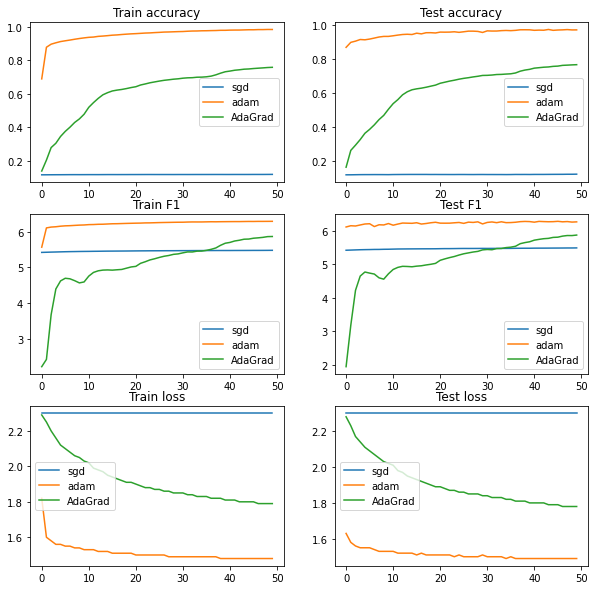

In [51]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

ax[0][0].set_title('Train accuracy')
ax[0][1].set_title('Test accuracy')
ax[1][0].set_title('Train F1')
ax[1][1].set_title('Test F1')
ax[2][0].set_title('Train loss')
ax[2][1].set_title('Test loss')

ax[0][0].plot(train_acc_sgd, label='sgd')
ax[0][0].plot(train_acc_adam, label='adam')
ax[0][0].plot(train_acc_adagrad, label='AdaGrad')
ax[0][0].legend()
ax[0][1].plot(test_acc_sgd, label='sgd')
ax[0][1].plot(test_acc_adam, label='adam')
ax[0][1].plot(test_acc_adagrad, label='AdaGrad')
ax[0][1].legend()

ax[1][0].plot(f1_train_sgd, label='sgd')
ax[1][0].plot(f1_train_adam, label='adam')
ax[1][0].plot(f1_train_adagrad, label='AdaGrad')
ax[1][0].legend()
ax[1][1].plot(f1_test_sgd, label='sgd')
ax[1][1].plot(f1_test_adam, label='adam')
ax[1][1].plot(f1_test_adagrad, label='AdaGrad')
ax[1][1].legend()

ax[2][0].plot(train_loss_sgd, label='sgd')
ax[2][0].plot(train_loss_adam, label='adam')
ax[2][0].plot(train_loss_adagrad, label='AdaGrad')
ax[2][0].legend()
ax[2][1].plot(test_loss_sgd, label='sgd')
ax[2][1].plot(test_loss_adam, label='adam')
ax[2][1].plot(test_loss_adagrad, label='AdaGrad')
ax[2][1].legend()

We clearly see that SGD gets stuck in a local minima, which hinders its learning. Therefore, all the metrics stay the same for SGD.
AdaGrad improves SGD by having a dynamic learning rate. In particular, it lowers the learning rate in proportion to the size of the gradients. Therefore, to reach a local minima, it would take much longer than SGD and Adam. This is seen in both the accuracy, loss and F1 score of AdaGrad.
After 50 epochs neither accuracy, nor the loss has converged to a value.
Adam take the main ideas from AdaGrad and RMSProp and converge to the boundary of the graph.

### 8.2.2 Schedulers (1 point) (**Bonus**)

In `torch.optim` module, we have a functionality called `scheduler` https://pytorch.org/docs/stable/optim.html & in several different flavour of schedulers i.e. in Pytorch Ignite and HuggingFace, we have a functionality called `warmup_steps`. Briefly explain why would we need to use a scheduler with warmup steps.

Because many optimizer, such as Adam, AdaGrad, and RMSProp, accumulate gradients - through the aggregation of sum or mean - the generalization that is achieved with these methods is quite bad (biased) in the first iterations because only a few gradients are averaged. Therefore, it could be that the optimizer "goes in the wrong direction" in the first iterations. Therefore, setting the learning rate to a low value in the early iteration allows the optimizer to optimize the parameters as well as accumulate a few gradient for the purpose of generalization before setting the learning rate to a high(er) value.